# IMDB review sentiment analysis through text preprocessing and classification and build model

## Part one import basic libraries and read data

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import os

In [86]:
DATA_PATH=Path('./dat/')
DATA_PATH.mkdir(exist_ok=True)
#if not os.path.exists('./dat/aclImdb_v1.tar.gz'):
if not os.path.exists('./dat/aclImdb'):
    !curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    !tar -xf aclImdb_v1.tar.gz -C {DATA_PATH}

#### read data

In [87]:
import numpy as np
CLASSES = ['neg', 'pos']#, 'unsup']
PATH=Path('./dat/aclImdb/')

def get_texts(path):
    texts,labels = [],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            #texts.append(fixup(fname.open('r', encoding='utf-8').read()))
            texts.append(fname.open('r', encoding='utf-8').read())
            labels.append(idx)
    #return np.array(texts),np.array(labels)
    return texts, labels

In [88]:
trn_texts,trn_labels=get_texts(PATH/'train')
tst_texts,tst_labels=get_texts(PATH/'test')

In [89]:
for t in trn_texts[:10]:
  print (t,"\n")

Whatever his name is (the writer and director) should be locked away in hopes garbage like this is never made again. This one is in a battle with some of the most awful movies of all time. Sometimes movies are bad in a way that they're actually sort of good. Not this one. This was so bad I got angry. Seriously. A drunken 10 year old could have come up with a better script. What a waste. ALL the actors were completely uninspired to work at all, the CGI was barely acceptable, the sequences of scenes were completely retarded and hurt the little bit of story there was, it's like he just decided, "I want this to happen and this to happen, but I don't care how we got there, just shoot it and put it in. Whatever, I'm going back to my trailer to pick my nose, if anyone calls for me, I'm not here." Shame on you whatever your name is. Shame on you. 

The direction struck me as poor man's Ingemar Bergman. The inaudible dialogue was annoying. The somber stoicism that all characters except Banderas

## Part two data preprocessing and build vocab

In [90]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))



def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def to_lowercase(text):
    return text.lower()


def replace_numbers(text):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)

def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):
    """
    :param words:
    :type words:
    :param stop_words: from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
    or
    from spacy.lang.en.stop_words import STOP_WORDS
    :type stop_words:
    :return:
    :rtype:
    """
    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
  text=sent_tokenize(text)
  return word_tokenize("".join(text))

In [91]:
# clean scrapping
import html
import unicodedata
import string

# regex
import re

# tokenization
import nltk
nltk.download('punkt')

## sent_tokenize
from nltk.tokenize import sent_tokenize
## word_tokenize
from nltk.tokenize import word_tokenize

# remove stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=stopwords.words('english')

# stemming
from nltk.stem import PorterStemmer

# lemmatization
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')


def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    #words = stem_words(words)# Either stem ovocar lemmatize

    #lemmatization is good in BOW
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ''.join(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [92]:
normalize_text(trn_texts[0])

'whatever name writer director lock away hope garbage like never make one battle awful movie time sometimes movie bad way theyre actually sort good one bad get angry seriously drunken year old could come better script waste actor completely uninspired work cgi barely acceptable sequence scene completely retard hurt little bite story like decide want happen happen dont care get shoot put whatever im go back trailer pick nose anyone call im shame whatever name shame'

In [93]:
def normalize_corpus (corpus):
  return [normalize_text(s) for s in corpus]

In [94]:
trn_texts=normalize_corpus(trn_texts)
tst_texts=normalize_corpus(tst_texts)

#### build vocab using keras Tokenizer with mode freq

In [95]:
# fit the tokenizer

from keras.preprocessing.text import Tokenizer
vocab_sz=10000
tok=Tokenizer(num_words=vocab_sz,oov_token="UNK")
tok.fit_on_texts(trn_texts+tst_texts)

tok.word_index

{'UNK': 1,
 'movie': 2,
 'film': 3,
 'one': 4,
 'make': 5,
 'like': 6,
 'see': 7,
 'get': 8,
 'time': 9,
 'good': 10,
 'character': 11,
 'watch': 12,
 'go': 13,
 'even': 14,
 'story': 15,
 'think': 16,
 'would': 17,
 'really': 18,
 'show': 19,
 'scene': 20,
 'well': 21,
 'look': 22,
 'say': 23,
 'much': 24,
 'know': 25,
 'end': 26,
 'people': 27,
 'great': 28,
 'bad': 29,
 'also': 30,
 'give': 31,
 'first': 32,
 'take': 33,
 'act': 34,
 'play': 35,
 'love': 36,
 'way': 37,
 'dont': 38,
 'come': 39,
 'thing': 40,
 'find': 41,
 'could': 42,
 'life': 43,
 'seem': 44,
 'work': 45,
 'many': 46,
 'plot': 47,
 'actor': 48,
 'want': 49,
 'two': 50,
 'never': 51,
 'year': 52,
 'try': 53,
 'best': 54,
 'little': 55,
 'ever': 56,
 'better': 57,
 'man': 58,
 'still': 59,
 'feel': 60,
 'part': 61,
 'something': 62,
 'lot': 63,
 'back': 64,
 'interest': 65,
 'im': 66,
 'director': 67,
 'real': 68,
 'guy': 69,
 'performance': 70,
 'doesnt': 71,
 'use': 72,
 'didnt': 73,
 'woman': 74,
 'though': 75,
 

In [96]:
x_train=tok.texts_to_matrix(trn_texts,mode='freq')
x_test=tok.texts_to_matrix(tst_texts,mode='freq')

In [97]:
y_train=np.asarray(trn_labels).astype('float32')
y_test=np.asarray(tst_labels).astype('float32')

In [98]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)

(25000, 10000)
(25000,)
(25000, 10000)
(25000,)


## Part three build network

In [99]:
from keras.layers import Dense
from keras.models import Sequential

model=Sequential()
model.add(Dense(16,activation='relu',input_shape=(10000,)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                160016    
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160305 (626.19 KB)
Trainable params: 160305 (626.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
from keras.losses import binary_crossentropy
from keras.optimizers import RMSprop
from keras.metrics import binary_accuracy

model.compile(optimizer=RMSprop(lr=0.01),loss=binary_crossentropy,metrics=[binary_accuracy])

In [101]:
# split data
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.4,random_state=42)

In [102]:
history=model.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=512,epochs=20)

Epoch 1/20
30/30 [==============================] - 3s 82ms/step - loss: 0.6929 - binary_accuracy: 0.5399 - val_loss: 0.6923 - val_binary_accuracy: 0.5047
Epoch 2/20
30/30 [==============================] - 1s 36ms/step - loss: 0.6917 - binary_accuracy: 0.6165 - val_loss: 0.6909 - val_binary_accuracy: 0.5399
Epoch 3/20
30/30 [==============================] - 1s 47ms/step - loss: 0.6899 - binary_accuracy: 0.6162 - val_loss: 0.6890 - val_binary_accuracy: 0.6411
Epoch 4/20
30/30 [==============================] - 2s 55ms/step - loss: 0.6872 - binary_accuracy: 0.6904 - val_loss: 0.6854 - val_binary_accuracy: 0.6982
Epoch 5/20
30/30 [==============================] - 2s 61ms/step - loss: 0.6831 - binary_accuracy: 0.7080 - val_loss: 0.6807 - val_binary_accuracy: 0.7111
Epoch 6/20
30/30 [==============================] - 2s 53ms/step - loss: 0.6772 - binary_accuracy: 0.7220 - val_loss: 0.6739 - val_binary_accuracy: 0.7126
Epoch 7/20
30/30 [==============================] - 1s 36ms/step - los

#### Evaluate the model

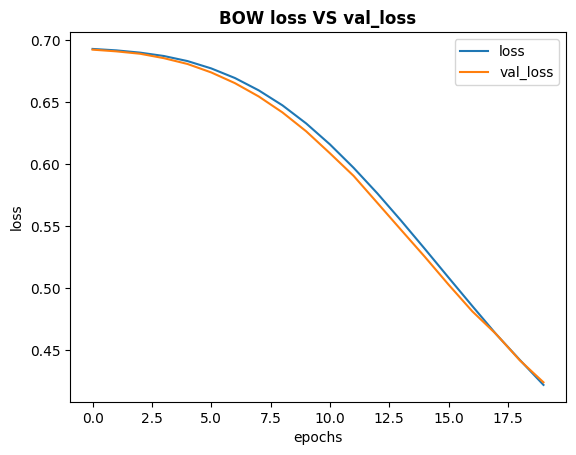

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])
plt.title("BOW loss VS val_loss",fontweight="bold")
plt.show()

In [104]:
from sklearn.metrics import accuracy_score

# Make predictions on test data
predictions = model.predict(x_train)

# Since the predictions are probabilities, we need to convert them to binary values
# You can use a threshold of 0.5 for binary classification
binary_predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_train, binary_predictions)

print("Accuracy on train data:", accuracy)

469/469 [==============================] - 1s 2ms/step
Accuracy on train data: 0.8504666666666667


In [105]:
# Make predictions on test data
predictions = model.predict(x_test)

# Since the predictions are probabilities, we need to convert them to binary values
# You can use a threshold of 0.5 for binary classification
binary_predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, binary_predictions)

print("Accuracy on test data:", accuracy)

782/782 [==============================] - 2s 3ms/step
Accuracy on test data: 0.83888


In [106]:
# Use the trained model to predict labels for the test data
predictions = model.predict(x_val)

# Convert predicted probabilities to binary labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_val,predicted_labels)

print("Accuracy on test set:", accuracy)

313/313 [==============================] - 1s 2ms/step
Accuracy on test set: 0.8418


### Show some predications of the model

In [107]:
review=[]
review.append(tst_texts[0])
review.append(tst_texts[1])
review.append(tst_texts[2])
review.append(tst_texts[3])
review.append(tst_texts[-1])
review.append(tst_texts[-2])
review.append(tst_texts[-3])
review.append(tst_texts[-4])

In [108]:
review_lbls=[]
review_lbls.append(tst_labels[0])
review_lbls.append(tst_labels[1])
review_lbls.append(tst_labels[2])
review_lbls.append(tst_labels[3])
review_lbls.append(tst_labels[-1])
review_lbls.append(tst_labels[-2])
review_lbls.append(tst_labels[-3])
review_lbls.append(tst_labels[-4])

In [109]:
text=[]
text.append(x_test[0])
text.append(x_test[1])
text.append(x_test[2])
text.append(x_test[3])
text.append(x_test[-1])
text.append(x_test[-2])
text.append(x_test[-3])
text.append(x_test[-4])
text=np.array(text)
text

array([[0.        , 0.08474576, 0.01694915, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02325581, 0.03488372, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.07894737, 0.02631579, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.14583333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.07317073, 0.01219512, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05555556, 0.0026455 , ..., 0.        , 0.        ,
        0.        ]])

In [110]:
labels=[]
labels.append(tst_labels[0])
labels.append(tst_labels[1])
labels.append(tst_labels[2])
labels.append(tst_labels[3])
labels.append(tst_labels[-1])
labels.append(tst_labels[-2])
labels.append(tst_labels[-3])
labels.append(tst_labels[-4])

In [111]:
# Make predictions on test data
predictions = model.predict(text)

# Since the predictions are probabilities, we need to convert them to binary values
# You can use a threshold of 0.5 for binary classification
binary_predictions = (predictions > 0.5).astype(int)

1/1 [==============================] - 0s 22ms/step


In [113]:
df=pd.DataFrame({'review':review,'labels':review_lbls,'pred_labels':list(binary_predictions)})
df['pred_labels'] = df['pred_labels'].apply(lambda x: x[0])
df

,review,labels,pred_labels
0,true one really expect anything sequel even lo...,0,0
1,low budget film set one location valley shield...,0,1
2,jealous husband hold car dealership hostage wi...,0,0
3,lowestrating reviewer sum sewage perfectly see...,0,0
4,course im bite prejudice time accurate portray...,1,1
5,imagine world everyone treat anyone nicely fou...,1,1
6,entirely sure stumble upon movie im glad initi...,1,1
7,walk coen movie quite know feel two best examp...,1,1


__Even if the accuracy achieved using the bag-of-words approach may not be as high as desired but it's satisfied, there are still several advantages to using this method for text classification, the most important thing is speed and feed data to neural networl__